In [1]:
from pyspark import SparkContext, SparkConf

In [2]:
app_name = 'telecom'

In [3]:
conf = SparkConf().setAppName(app_name)
sc = SparkContext.getOrCreate(conf=conf)

In [4]:
sc.applicationId

'local-1576431408320'

In [6]:
# Load File
# The file is not included in GitHub repository because of large file size (482 MB)
log_file = sc.textFile('..\\pyspark-training\\data\\access.log')
log_file.take(3)

['',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -']

In [8]:
# Find out how many 404 HTTP codes are in access logs
log_file.filter(lambda x: "404" in x).count()

227586

In [9]:
import re

In [10]:
string_test = '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -'
print(re.search("https?://[^\s]+", string_test).group(0))

http://almhuette-raith.at/administrator/


In [11]:
# Find out which URLs are broken
log_file.filter(lambda x: "404" in x
               ).filter(lambda x: "http" in x
                       ).map(lambda x: re.search("https?://[^\s]+", x)
                            ).filter(lambda x: x is not None
                                    ).map(lambda x: x.group(0)
                                         ).distinct().collect()

['http://almhuette-raith.at/modules/mod_feed/widget.php',
 'http://almhuette-raith.at/images/banners/wpconfig-new.php',
 'http://almhuette-raith.at/doc.php',
 'http://almhuette-raith.at/images/jquery.php',
 'http://almhuette-raith.at/media/editors/tinymce/jscripts/tiny_mce/plugins/autosave/langs/main.php',
 'http://almhuette-raith.at/index.php?option=com_phocagallery&amp;view=category&amp;id=4:ferienwohnung2&amp;Itemid=0',
 'http://almhuette-raith.at/wp-admin/images/system.php',
 'http://almhuette-raith.at/libraries/joomla/event/seller.php',
 'http://almhuette-raith.at/modules/mod_itpgads_5034/plugins.php',
 'http://almhuette-raith.at/modules/mod_webantivirus/mod_webantivirus.php',
 'http://almhuette-raith.at/tmp/sfx.php.suspected',
 'http://almhuette-raith.at/.git/',
 'http://lyrica.page4.com/',
 'http://almhuette-raith.at/libraries/joomla/access/strangers.php',
 'http://almhuette-raith.at/libraries/joomla/base/wp-error.php',
 'http://almhuette-raith.at/default.php',
 'http://almhuett

In [12]:
# Verify there are no null columns in the original dataset
logs = log_file.filter(lambda x: x != '').map(lambda x: x.split("-")).map(lambda x: [x[0], x[2], x[3]])
logs.filter(lambda x: (x[0].lower() in ['', ' ', 'null']) | (x[1].lower() in ['', ' ', 'null']) | (x[2].lower() in ['', ' ', 'null'])).count()

384739

There are 384739 records with null columns.

In [13]:
# Replace null values with constants such as 0
logs_notNull = logs.map(lambda lst: [0 if (x == ' ') | (x == '') | (x.lower() == 'null') else x for x in lst])
logs_notNull.take(3)

[['109.169.248.247 ',
  ' [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 ',
  ' Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 '],
 ['109.169.248.247 ',
  ' [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette',
  'raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 '],
 ['46.72.177.4 ',
  ' [12/Dec/2015:18:31:08 +0100] GET /administrator/ HTTP/1.1 200 4263 ',
  ' Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 ']]

In [14]:
# Parse timestamp to readable date
date = logs_notNull.map(lambda x: x[1]).map(lambda x: x.split(' ')[1][1:12])
date.take(5)

['12/Dec/2015', '12/Dec/2015', '12/Dec/2015', '12/Dec/2015', '12/Dec/2015']

In [18]:
# Describe which HTTP status values appear in data and how many
http_status = logs_notNull.map(lambda x: x[1]).map(lambda x: x.split(" ")).filter(lambda x: len(x) > 6).map(lambda x: x[6])
grouped_status = http_status.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a+b).collect()
grouped_status

[('501', 93),
 ('206', 1880),
 ('400', 23),
 ('303', 247),
 ('200', 950769),
 ('401', 2),
 ('301', 538),
 ('500', 2555),
 ('403', 1861),
 ('406', 53),
 ('304', 6086),
 ('405', 28),
 ('HTTP/1.1', 13),
 ('404', 192591)]

In [19]:
import matplotlib.pyplot as plt

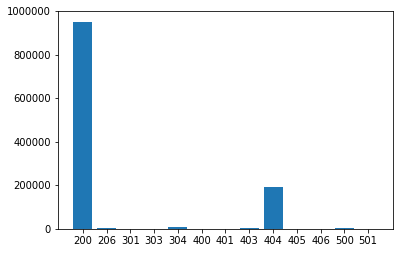

In [20]:
# Display the above state in chart
x = [x[0] for x in grouped_status if x[0] != 'HTTP/1.1']
y = [x[1] for x in grouped_status if x[0] != 'HTTP/1.1']
plt.bar(x, y)
plt.show()

In [23]:
# How many unique hosts are there in the entire log and their average request
hosts = logs_notNull.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b: a+b)
print("There are {} hosts in the entire log.".format(hosts.keys().count()))
print("Average number of requests for each host is {}.".format( hosts.values().mean()))

There are 40836 hosts in the entire log.
Average number of requests for each host is 57.25355078851999.
